In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls
%cd drive/MyDrive/9444/group_ass/VOC2012

drive  sample_data
/content/drive/MyDrive/9444/group_ass/VOC2012


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.6/877.6 kB 31.8 MB/s eta 0:00:00
ERROR: Operation cancelled by user


In [2]:
import os
import xml.etree.ElementTree as ET
# from ultralytics import YOLO
from collections import defaultdict, Counter
import json
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler, random_split, Subset
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import random
from albumentations import (
    Compose, HorizontalFlip, VerticalFlip, Rotate, RandomBrightnessContrast, Normalize, BboxParams
)
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## 1. Data Preprocessing
- Our dataset is from ScienceDB (scidb.cn), the url is : https://www.scidb.cn/en/s/6bq2M3</br>

- Datasets are in PASCAL VOC format</br>
- To facilitate uniform data reading, we point the current working directory to `/root` </br>
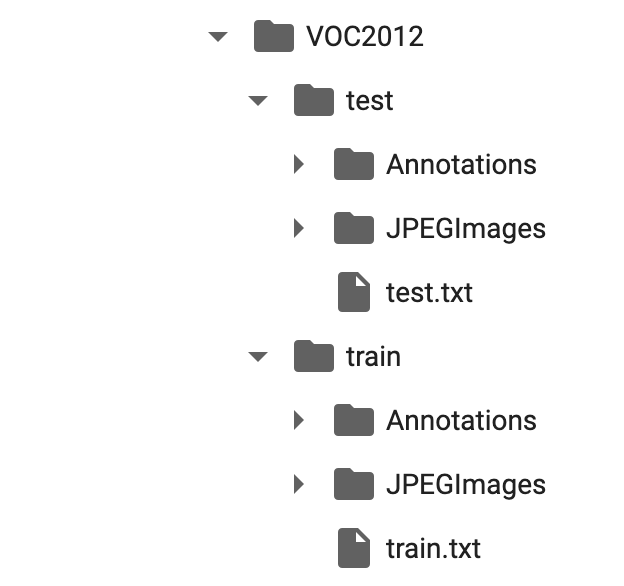

In [3]:
os.chdir('/content/drive/MyDrive/9444/group_ass')

In [ ]:
# set the new dataset path
# root_path = './new_dumpsite_data'
# train_file_Annotations = os.path.join(root_path, "train", "Annotations")
# test_file_Annotations = os.path.join(root_path, "test", "Annotations")

# # Create directories if they do not exist
# os.makedirs(train_file_Annotations, exist_ok=True)
# os.makedirs(test_file_Annotations, exist_ok=True)

# print(os.getcwd())
# print(f"Train Annotations directory: {train_file_Annotations}")
# print(f"Test Annotations directory: {test_file_Annotations}")

/content/drive/MyDrive/9444/group_ass
Train Annotations directory: ./new_dumpsite_data/train/Annotations
Test Annotations directory: ./new_dumpsite_data/test/Annotations


In [8]:
# convert annotation files to find How many labels are there
def convert_annotation_find_labels(path):
  labels = []
  for each_xml in os.listdir(path):
      pic_xml = os.path.join(path, each_xml)
      tree = ET.parse(pic_xml)
      root = tree.getroot()
      for ele in root.findall('object'):
          label = ele.find('name').text
          labels.append(label)
  set_labels = set(labels)
  print(path, set_labels)
  return labels

train_object_labels = convert_annotation_find_labels('VOC2012/train/Annotations')
test_object_labels = convert_annotation_find_labels('VOC2012/test/Annotations')

VOC2012/train/Annotations {'industry waste', 'domestic garbage', 'construction waste', 'mining waste', 'agriculture forestry', 'disposed garbage'}
VOC2012/test/Annotations {'domestic garbage', 'agriculture forestry', 'construction waste', 'disposed garbage'}


In [9]:
with open('./label_map.json', 'r') as json_file:
  label_map = json.load(json_file)
label_name = {v : k for k, v in label_map.items()}

In [10]:
# Number of statistics for each label
name_number = defaultdict(int)
for index, class_name in enumerate(train_object_labels):
  name_number[label_map[class_name]] += 1
  train_object_labels[index] = label_map[class_name]
print('train_object_labels', train_object_labels)

train_object_labels [0, 0, 0, 2, 0, 5, 5, 5, 5, 0, 0, 0, 0, 5, 0, 5, 5, 0, 5, 0, 5, 0, 5, 0, 0, 0, 0, 2, 0, 0, 0, 0, 5, 0, 5, 5, 5, 5, 5, 0, 2, 0, 2, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 2, 0, 0, 0, 0, 0, 5, 5, 0, 2, 0, 0, 0, 0, 5, 5, 5, 0, 0, 5, 5, 0, 5, 2, 0, 0, 0, 5, 2, 0, 5, 0, 5, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 5, 5, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5

In [11]:
df = pd.Series(data=name_number.values(), index=list(label_name[name] for name in name_number.keys()), name="train_labels_distribution")
df

,train_labels_distribution
domestic garbage,2301
agriculture forestry,247
construction waste,581
disposed garbage,9
mining waste,1
industry waste,1


## 1.2 Calculation of category weights based on imbalances

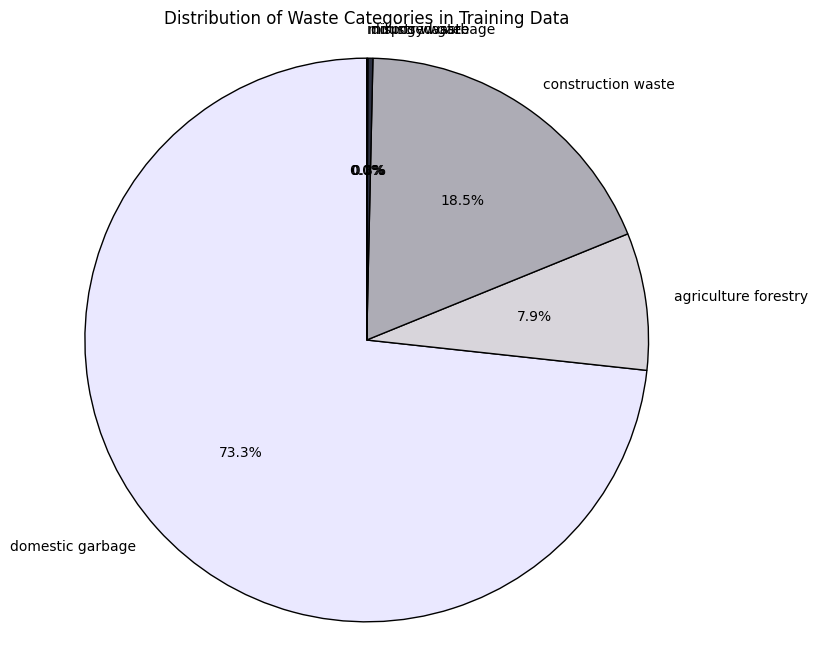

In [ ]:
# Percentage of each category of visualization
# Create a pie chart
plt.figure(figsize=(8, 8))  # Optional: to make the pie chart bigger

plt.pie([2301, 247, 581, 9, 1, 1],
    labels=list(label_name[name] for name in name_number.keys()),
    autopct='%1.1f%%',  # Display percentage with one decimal place
    startangle=90,      # Rotate the start of the pie chart
    wedgeprops={'edgecolor': 'black'},  # Add border to slices for clarity
    colors=['#EAE8FF','#D8D5DB','#ADACB5','#2D3142', '#B0D7FF', '#FFB3E6'])  # Custom colors

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Title (Optional)
plt.title('Distribution of Waste Categories in Training Data')

# Show the pie chart
plt.show()


In [ ]:
def check_image_annotation_consistency(image_dir, annotation_dir):
    image_files = set([os.path.splitext(f)[0] for f in os.listdir(image_dir)])
    annotation_files = set([os.path.splitext(f)[0] for f in os.listdir(annotation_dir)])

    missing_images = annotation_files - image_files
    missing_annotations = image_files - annotation_files

    if missing_images:
        print(f"Missing images for annotations: {missing_images}")
    if missing_annotations:
        print(f"Missing annotations for images: {missing_annotations}")
    if not missing_images and not missing_annotations:
        print("All images and annotations are consistent.")

# Checking the consistency of the training and test sets
check_image_annotation_consistency('VOC2012/train/JPEGImages', 'VOC2012/train/Annotations')
check_image_annotation_consistency('VOC2012/test/JPEGImages', 'VOC2012/test/Annotations')

All images and annotations are consistent.
All images and annotations are consistent.


## 1.3 Data Processing

As shown in the figure above, due to the uneven distribution of each category in the training set, it will lead to unfair training results, so we use data enhancement, category weight adjustment, and oversampling to make the proportion of images in each category reach a relative balance
- Data augmentation: data augmentation (rotation, translation, scaling, etc.) is applied to small categories to expand the sample size.
- **Category** weighting: assign larger weights to small categories during training to reduce the impact of category imbalance on the model.




In [20]:
class GarbageDataset(Dataset):
  def __init__(self, root, mode, output_dir=None, transforms=None, split_ratio=0.2, shuffle=True):
    self.root = root
    self.mode = mode
    self.transforms = transforms
    self.image_dir = os.path.join(root, 'JPEGImages')
    self.annotation_dir = os.path.join(root, 'Annotations')
    self.output_image_dir = os.path.join(output_dir, mode, "JPEGImages")  # transform image saved directories
    self.output_annotation_dir = os.path.join(output_dir, mode, 'Annotations')  # transform annotation saved directories

    # If output_dir is specified and the directory does not exist, create the directory
    # Create output directories if they don't exist
    os.makedirs(self.output_image_dir, exist_ok=True)
    os.makedirs(self.output_annotation_dir, exist_ok=True)

    # plan1: split inside
    # Load image IDs from text file
    # text_file = os.path.join(root, 'train.txt')
    # with open(text_file, 'r') as f:
    #   self.img_ids = f.read().strip().split()

    # # Split the dataset into train and validation sets
    # train_ids, val_ids = train_test_split(self.img_ids, train_size=split_ratio, shuffle=shuffle, random_state=42)

    # if mode == 'train':
    #   self.img_ids = train_ids
    # elif mode == 'valid':
    #   self.img_ids = val_ids
    # elif mode == 'test':
    #   text_file = os.path.join(root, 'test.txt')
    #   with open(text_file, 'r') as f:
    #       self.img_ids = f.read().strip().split()
    # else:
    #   raise ValueError("Invalid mode. Use 'train', 'valid', or 'test'.")

    # plan2:
    # Load image IDs from text file
    if mode == 'train':
      text_file = os.path.join(root, 'train.txt')
    elif mode == 'valid':
      text_file = os.path.join(root, 'train.txt')
    elif mode == 'test':
      text_file = os.path.join(root, 'test.txt')
    else:
      raise ValueError("Invalid mode. Use 'train', 'valid', or 'test'.")

    with open(text_file, 'r') as f:
      self.img_ids = f.read().strip().split()

  def __len__(self):
        return len(self.img_ids)

  def __getitem__(self, index):
    img_id = self.img_ids[index]
    img_path = os.path.join(self.image_dir, img_id + '.jpg')
    annotation_path = os.path.join(self.annotation_dir, img_id + '.xml')

    img = np.array(Image.open(img_path).convert('RGB'))

    # Parse the XMl annotation files
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    # Initialize lists for bounding boxes and labels
    boxes = []
    labels = []

    # Iterate over each obj in the XML files
    for obj in root.findall('object'):
        label = obj.find('name').text

        # Mapping the obj name to a label
        if label in label_map:
          labels.append(label_map[label])
        else:
          continue # skip labels that are not in the label_map

        # Extract bounding box coordinates
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        # Create a list for the bounding box coordinates
        box = [xmin, ymin, xmax, ymax]
        boxes.append(box)
    # Convert lists to tensors
    boxes = torch.tensor(boxes, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.int64)

    # Prepare the final target dictionary containing bounding boxes and labels
    target = {
        "boxes": boxes,
        "labels": labels
    }

    if self.transforms is not None:
      if self.mode == "train":
        while True:
          img_copy, target_copy = img.copy(), target.copy()
          transformed = self.transforms(image=img_copy, bboxes=target_copy['boxes'].tolist(), labels=target_copy['labels'].tolist())
          img_copy = transformed['image']
          target_copy['boxes'] = torch.tensor(transformed['bboxes'], dtype=torch.float32)
          target_copy['labels'] = torch.tensor(transformed['labels'], dtype=torch.int64)
          if torch.numel(target_copy['boxes']) > 0:
            img, target = img_copy, target_copy
            break
      else:
        img = self.transforms(img)

      if self.output_image_dir and self.output_annotation_dir:
        output_img_path = os.path.join(self.output_image_dir, img_id + ".jpg")
        processed_image = (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)  # Convert to uint8 and back to RGB
        cv2.imwrite(output_img_path, cv2.cvtColor(processed_image, cv2.COLOR_RGB2BGR))

        # Save the augmented XML annotation
        output_annotation_path = os.path.join(self.output_annotation_dir, img_id + '.xml')
        tree.write(output_annotation_path, encoding='utf-8', xml_declaration=True)

      return {'image':img, 'boxes':target['boxes'], 'labels':target['labels']}
  def load_annotations(self):
    """
    load_annotations function attempt to store the classes appeared in each image to recompute the image weight
    Returns:
        list : the labels in each image
    """
    data_infos = []
    for index in self.img_ids:
      ann_path = os.path.join(self.annotation_dir, f"{index}.xml")
      tree = ET.parse(ann_path)
      root = tree.getroot()
      temp_labels = []
      for obj in root.findall("object"):
        label = obj.find("name").text
        temp_labels.append(label_map[label])
      data_infos.append(temp_labels)
    print('data_infos: ', f'{self.mode}: {index}/{len(self.img_ids)}')
    return data_infos

  def unnormalize(self, image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = torch.tensor(mean)[:, None, None]
    std = torch.tensor(std)[:, None, None]
    return image * std + mean

In [13]:
# Define transformations using Albumentations for training
train_transform = Compose(
  [
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    Rotate(limit=90, p=0.5),
    RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()  # Convert to tensor after augmentations
  ],
  bbox_params=BboxParams(format='pascal_voc', label_fields=['labels'])
)

# Define transformations for testing/validation using Torchvision.transforms
test_transform = transforms.Compose([
  transforms.ToTensor(),  # Convert PIL images to tensors
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Apply normalization
])

# Organize transforms into a dictionary for easier access
transform = {
  "train": train_transform,
  "test": test_transform
}

## 1.4 Split Train Dataset to train dataset and valitation dataset

In [15]:
train_dataset = GarbageDataset(root='VOC2012/train', mode='train', output_dir='./new_dumpsite_data', transforms=transform["train"])

torch.manual_seed(42)
np.random.seed(42)
validation_split = 0.2
dataset_size = len(train_dataset)
print('dataset_size: ', dataset_size)

validation_size = int(validation_split * dataset_size)
train_size = dataset_size - validation_size

# Split `train_dataset` into train and validation indices
train_indices, val_indices = random_split(range(dataset_size), [train_size, validation_size])

# Create training and validation subsets from `train_dataset`
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

for idx in range(len(train_subset)):
  sample = train_subset[idx]
  print(f"Train Dataset Processed {idx + 1}/{len(train_subset)}: Image ID {train_dataset.img_ids[train_subset.indices[idx]]}")
  # if idx == 10:
  #   break
for idx in range(len(val_subset)):
  sample = val_subset[idx]
  print(f"Validation Dataset Processed {idx + 1}/{len(val_subset)}: Image ID {train_dataset.img_ids[val_subset.indices[idx]]}")
  # if idx == 10:
  #   break


dataset_size:  2671


In [16]:
def collate_fn(batch):
  images = []
  targets = []
  for obj in batch:
    if obj:
      images.append(obj['image'])
      targets.append({'boxes':obj['boxes'], 'labels':obj['labels']})
  images = torch.stack(images, dim=0)
  return images, targets

In [19]:
# Calculate image weights for the train_subset
n_c = defaultdict(int)
for idx in train_subset.indices:
  print('train_subset.indices:', idx)
  # The 'labels' key might return a tensor.
  # If it's a single-element tensor, use .item() to get the scalar value.
  # If it's a multi-element tensor, iterate through it or select the appropriate element.
  labels = train_dataset[idx]['labels']
  if labels.dim() == 0:  # Check if it's a 0-dimensional tensor (scalar)
    test = int(labels.item())
  else:
    # If 'labels' is a multi-element tensor, handle it appropriately
    # For instance, if you want to count occurrences of each label:
    for label in labels:
        n_c[int(label.item())] += 1
    continue  # Skip the rest of the loop for this iteration

  n_c[test] += 1

labels_weights = {key : 1.0 / value for key, value in n_c.items()}
annotations = train_dataset.load_annotations()
image_weights = []
for img_classes in annotations:
  img_weight = labels_weights[img_classes[0]]
  image_weights.append(img_weight)
np.save('image_weights.npy', np.array(image_weights))

# Now, image_weights should have the correct size for train_subset
train_image_weights = [image_weights[i] for i in range(len(train_subset))]
# Use range to generate indices from 0 to len(train_subset) -1
# since image_weights is now calculated based on train_subset

sampler = WeightedRandomSampler(weights=train_image_weights, num_samples=len(train_image_weights), replacement=True)

train_dataloader = DataLoader(train_subset, batch_size=12, collate_fn=collate_fn, sampler=sampler)
val_dataloader = DataLoader(val_subset, batch_size=8, collate_fn=collate_fn)

test_dataset = GarbageDataset(root='VOC2012/test', mode='test', output_dir='./new_dumpsite_data', transforms=transform["test"])
test_dataloader = DataLoader(test_dataset, batch_size=4, collate_fn=collate_fn)

data_infos:  N90304/2671: 
